In [2]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping, simpleGrouping
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [3]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


Files already downloaded and verified
cuda


In [4]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
round_set = [x for x in round_set if x >= 30]
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30] 4
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [5]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")
print(formatted_date_time)

corr_set = []
fv_set = []
normal_nums = int(client_max)
attack_nums = int(client_max)
total_nums = normal_nums+attack_nums

for idround, round_number in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{round_number}_normal'][0:normal_nums] + modelpth_dict[f'{round_number}_attack'][0:attack_nums]
    global_model_pth = [gm for gm in gmodelpth_set if (int(re.findall(r'-?\d+', gm)[-1]) == round_number)][0]
    print(global_model_pth)
    r_corr = np.zeros((total_nums, total_nums, 1))

    fvlist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    
    g_gradient = getGradients(modelpth=global_model_pth, model=model, dataloader=Dataloader)

    for idx, modelp1 in enumerate(r_modelpth_set):
        model.load_state_dict(torch.load(modelp1))
        gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
     
    # print(gradientlist[0])
    # 定义权重键名列表
    global_grad = [g_gradient[key] for key in weight_keys]

    # 使用列表推导式创建 local_grad 和 global_grad 列表

    for client_id, v in enumerate(gradientlist):
        local_grad = [v[key] for key in weight_keys]
        corrlist = []
        for layer_id, _ in enumerate(local_grad):
            nd_vector = np.prod(local_grad[layer_id].cpu().shape)

            lg = local_grad[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])
            gg = global_grad[layer_id].cpu().reshape(minimizeProduct(nd_vector)[0])

            l = linear_CKA(lg.T, gg.T)
            k = kernel_CKA(lg.T, gg.T)

            corrlist.append((l+k)/2)

        fvlist.append(np.array(corrlist))
        # print(fvlist[-1])

    
    # save fvlist
    fv_set.append([round_number, fvlist])

    for id1, v1 in enumerate(fvlist):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(fvlist):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            

            r_corr[id1][id2] = 1-np.linalg.norm(v1-v2)
    
    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)

print(len(fv_set))
    

2024-04-27 19:31:09
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/attack_portion0.4_model_36.pt
Files already downloaded and verified


2024-04-27 19:31:10.980157: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 19:31:11.003244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 19:31:11.369361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/attack_portion0.4_model_34.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/attack_portion0.4_model_32.pt
Files already downloaded and verified
/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern04-27--19-19-23/fed/attack_portion0.4_model_30.pt
Files already downloaded and verified
4
(60, 60, 1)
4


In [6]:
np.savetxt(f"./data/corrset_temp_v4_{formatted_date_time}_{round_set}_[{normal_nums}_{attack_nums}].txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))
np.savetxt(f"./data/fvset_temp_v4_{formatted_date_time}_{round_set}_[{normal_nums}_{attack_nums}].txt",np.array([row[1] for row in fv_set]).reshape(len(fv_set), -1))
print(formatted_date_time)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

# PCODE

In [ ]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping

36 (36, 36)


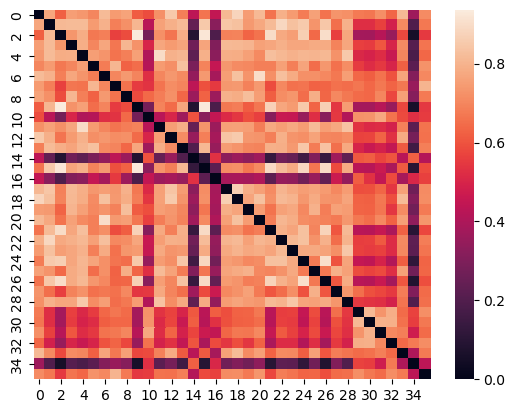

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


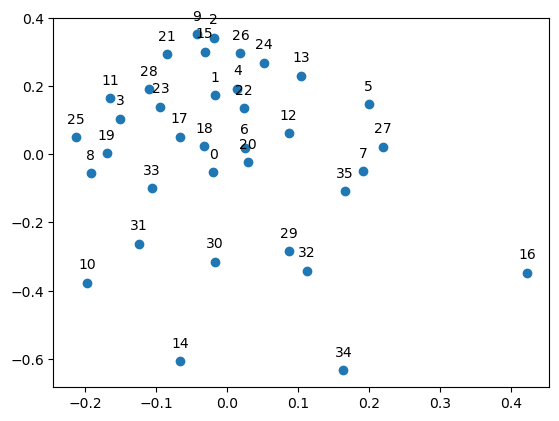

d 0 0 0.0 inf []
d 0 1 0.0 0.37999040965849273 [[16, 29]]
d 0 2 0.0 0.3745898019782723 [[14, 34]]
d 0 3 0.0 0.32509427960079784 [[32, 34]]
d 0 4 0.0 0.28144714733007636 [[0, 31]]
d 0 5 0.0 0.2274338226574969 [[10, 31]]
d 0 6 0.0 0.20878379237868794 [[25, 27]]
d 0 7 0.0 0.20761037655239922 [[30, 32]]
d 0 8 0.0 0.20557239849759235 [[30, 31]]
d 0 9 0.0 0.19586078103124338 [[7, 35]]
d 0 10 0.0 0.19468641321462798 [[5, 7]]
d 0 11 0.0 0.192156793242092 [[3, 8]]
d 0 12 0.0 0.18610030284850454 [[29, 30]]
d 0 13 0.0 0.18365738785298036 [[1, 3]]
d 0 14 0.0 0.18257785826294926 [[11, 25]]
d 0 15 0.0 0.18210303983938736 [[18, 33]]
d 0 16 0.0 0.17362478884860777 [[8, 19]]
d 0 17 0.0 0.16910755794108812 [[1, 23]]
d 0 18 0.0 0.1678245569147956 [[18, 20]]
d 0 19 0.0 0.16602682142624758 [[5, 13]]
d 0 20 0.0 0.15563082336433487 [[1, 17]]
d 0 21 0.0 0.15436968804856455 [[23, 28]]
d 0 22 0.0 0.15173951482142023 [[13, 24]]
d 0 23 0.0 0.1489953058795611 [[4, 28]]
d 0 24 0.0 0.1459034903531904 [[12, 18]]
d 0 

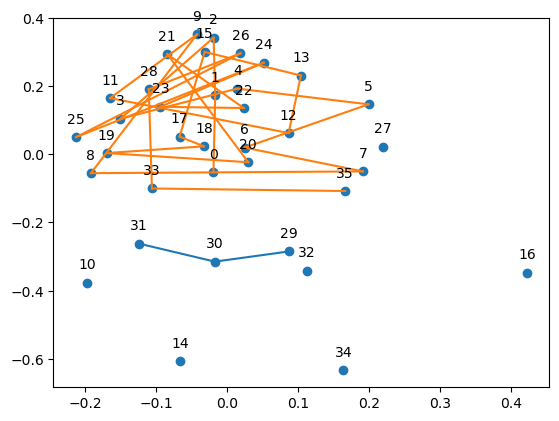

persistence =0.20878379237868794, finding: [30, 32]
 [[32, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 33, 35]]
merging
[[32]]
[[0, 0]]
pbow:
[array([3., 0., 0., 0.]), array([ 7.,  2.,  7., 10.])]
[[ 0. 13.]
 [13.  0.]]
score x0.5166666666666667: [0.75] [0.07407407407407407] 
total score : 0.9166666666666666

[[32, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 33, 35]]


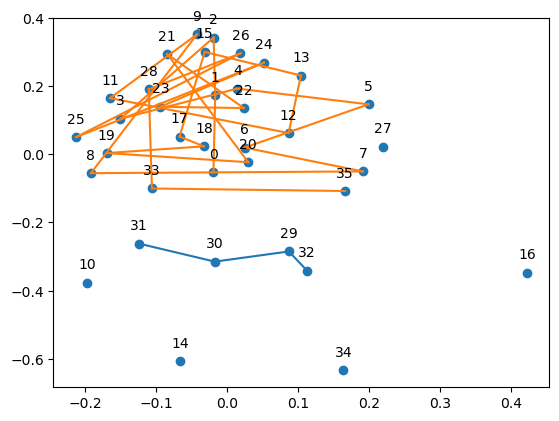

persistence =0.2274338226574969, finding: [25, 27]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 35], [32, 29, 30, 31]]
merging
[[27]]
[[1, 0]]
pbow:
[array([ 7.,  7., 11.,  2.]), array([0., 3., 0., 0.])]
[[ 0.         13.78404875]
 [13.78404875  0.        ]]
score x0.5333333333333333: [0.07142857142857142] [0.75] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 35], [32, 29, 30, 31]]


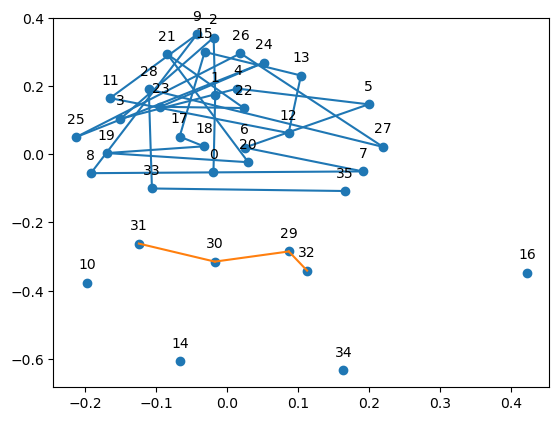

persistence =0.28144714733007636, finding: [10, 31]
 [[32, 10, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 35]]
merging
[[10]]
[[1, 0]]
pbow:
[array([3., 0., 0., 0., 1.]), array([4., 2., 7., 7., 7.])]
[[ 0.         11.78982612]
 [11.78982612  0.        ]]
score x0.55: [0.6] [0.07142857142857142] 
total score : 0.8888888888888888

[[32, 10, 29, 30, 31], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 35]]


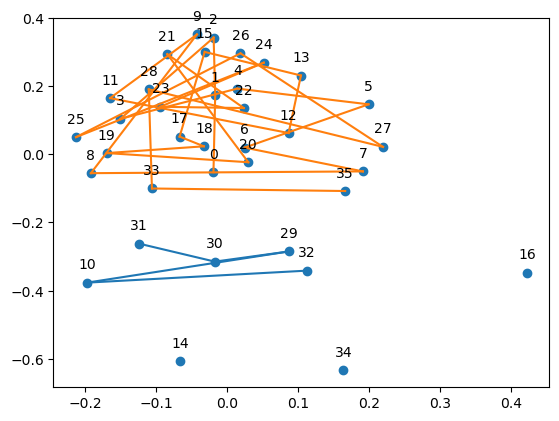

persistence =0.32509427960079784, finding: [0, 31]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 35], [10, 29, 30, 31, 32]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  11.789826122551595 11.789826122551595
score x0.55: [0.15151515151515152] 
total score : 0.8611111111111112

persistence =0.3745898019782723, finding: [32, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[34]]
[[0, 0]]
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.37999040965849273, finding: [14, 34]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[14]]
[[0, 0]]
score x0.5833333333333334: [0.17142

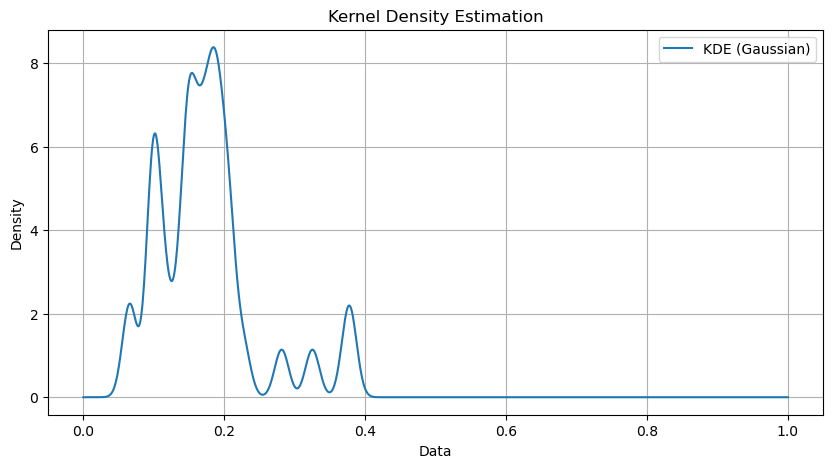

34 (36, 36)


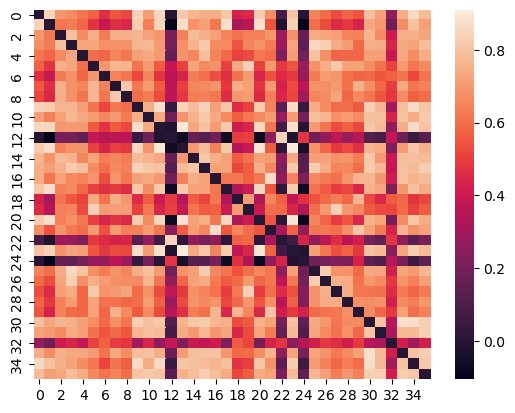

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


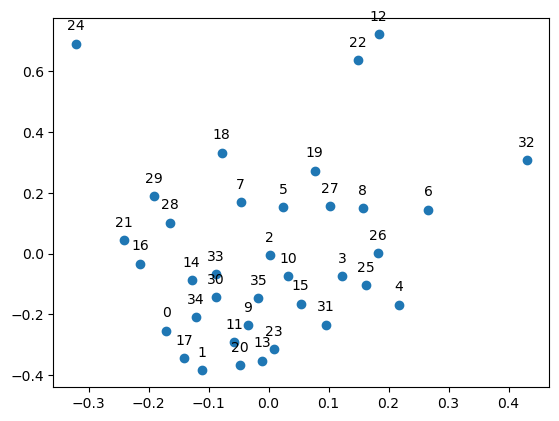

d 0 0 0.0 inf []
d 0 1 0.0 0.5221474690833143 [[12, 24]]
d 0 2 0.0 0.42851215141242394 [[6, 32]]
d 0 3 0.0 0.4073746574677636 [[19, 22]]
d 0 4 0.0 0.2940637536419941 [[6, 26]]
d 0 5 0.0 0.25575063486144767 [[26, 28]]
d 0 6 0.0 0.2408791954044962 [[26, 27]]
d 0 7 0.0 0.2312834278490753 [[18, 29]]
d 0 8 0.0 0.23095745999266892 [[5, 7]]
d 0 9 0.0 0.2061900669746516 [[2, 3]]
d 0 10 0.0 0.19834477134771966 [[16, 33]]
d 0 11 0.0 0.19711007258799262 [[4, 25]]
d 0 12 0.0 0.19604769930938426 [[21, 29]]
d 0 13 0.0 0.1823199749785116 [[7, 8]]
d 0 14 0.0 0.18122891106987815 [[14, 30]]
d 0 15 0.0 0.17764940248318928 [[10, 35]]
d 0 16 0.0 0.17052723203466047 [[15, 25]]
d 0 17 0.0 0.16843350138725288 [[30, 35]]
d 0 18 0.0 0.16798757683851473 [[31, 35]]
d 0 19 0.0 0.1659793016871588 [[3, 26]]
d 0 20 0.0 0.16477257306232218 [[5, 19]]
d 0 21 0.0 0.1631752418997452 [[19, 27]]
d 0 22 0.0 0.15551773159303317 [[9, 15]]
d 0 23 0.0 0.15540635907217903 [[12, 22]]
d 0 24 0.0 0.14450059233917134 [[3, 25]]
d 0 25

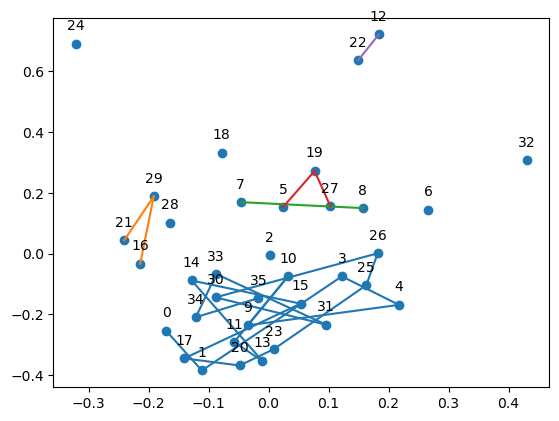

persistence =0.2061900669746516, finding: [16, 33]
 [[0, 1, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [7, 8], [27, 19, 5], [12, 22]]
merging
[[16, 21, 29], [0, 1, 3, 4, 9, 10, 11, 13, 14, 15, 17, 20, 23, 25, 26, 30, 31, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  12.206555615733702 13.038404810405298
pbow:
[array([10., 12.]), array([1., 0.]), array([2., 0.]), array([1., 0.])]
[[ 0.        15.        14.4222051 15.       ]
 [15.         0.         1.         0.       ]
 [14.4222051  1.         0.         1.       ]
 [15.         0.         1.         0.       ]]
score x0.5: [0.21739130434782608] [0.0] [0.0] [0.0] 
total score : 0.8611111111111112

[[0, 1, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [7, 8], [27, 19, 5], [12, 22]]


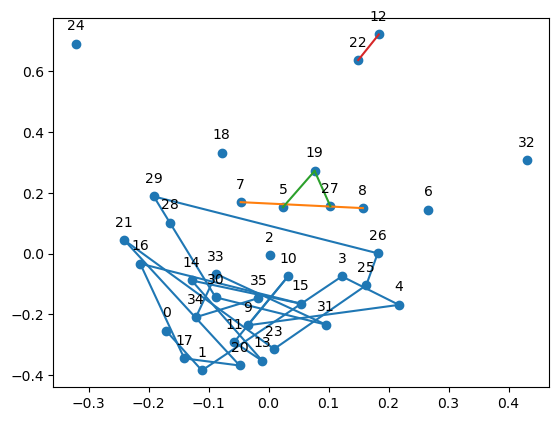

persistence =0.23095745999266892, finding: [2, 3]
 [[0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [7, 8], [27, 19, 5], [12, 22]]
merging
[[2]]
[[0, 0]]
pbow:
[array([11., 12.]), array([1., 0.]), array([2., 0.]), array([1., 0.])]
[[ 0.         15.62049935 15.         15.62049935]
 [15.62049935  0.          1.          0.        ]
 [15.          1.          0.          1.        ]
 [15.62049935  0.          1.          0.        ]]
score x0.5166666666666667: [0.20833333333333334] [0.0] [0.0] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [7, 8], [27, 19, 5], [12, 22]]


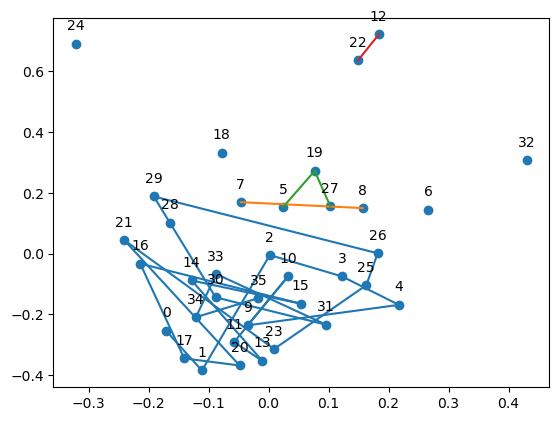

persistence =0.2312834278490753, finding: [5, 7]
 [[5, 7, 8, 19, 27], [0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [12, 22]]
merging
[[19, 5, 27], [7, 8]]
[[1, 0], [2, 0]]
[0, 1, 2]
merging with pbow_d:  1.0 15.620499351813308
pbow:
[array([0., 4.]), array([12., 11.]), array([0., 1.])]
[[ 0.         13.89244399  3.        ]
 [13.89244399  0.         15.62049935]
 [ 3.         15.62049935  0.        ]]
score x0.5166666666666667: [0.0] [0.20833333333333334] [0.0] 
total score : 0.8611111111111112

[[5, 7, 8, 19, 27], [0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [12, 22]]


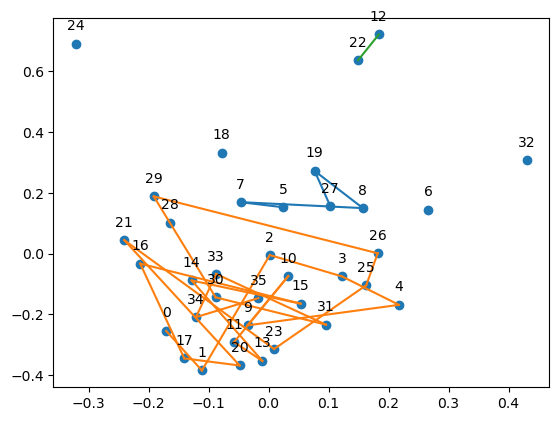

persistence =0.2408791954044962, finding: [18, 29]
 [[0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [5, 7, 8, 19, 27], [12, 22]]
merging
[[18]]
[[1, 0]]
pbow:
[array([12., 12.]), array([0., 4.]), array([0., 1.])]
[[ 0.        14.4222051 16.2788206]
 [14.4222051  0.         3.       ]
 [16.2788206  3.         0.       ]]
score x0.5333333333333333: [0.2] [0.0] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35], [5, 7, 8, 19, 27], [12, 22]]


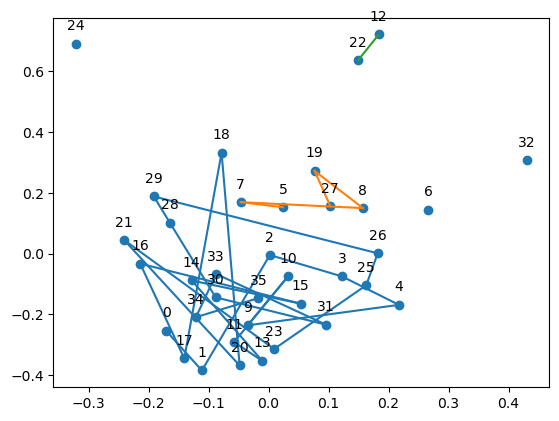

persistence =0.25575063486144767, finding: [26, 27]
 [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35], [12, 22]]
merging
[[5, 7, 8, 19, 27], [0, 1, 2, 3, 4, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 29, 30, 31, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.422205101855956 16.278820596099706
pbow:
[array([13., 16.]), array([1., 0.])]
[[ 0. 20.]
 [20.  0.]]
score x0.5333333333333333: [0.16666666666666666] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 31, 33, 34, 35], [12, 22]]


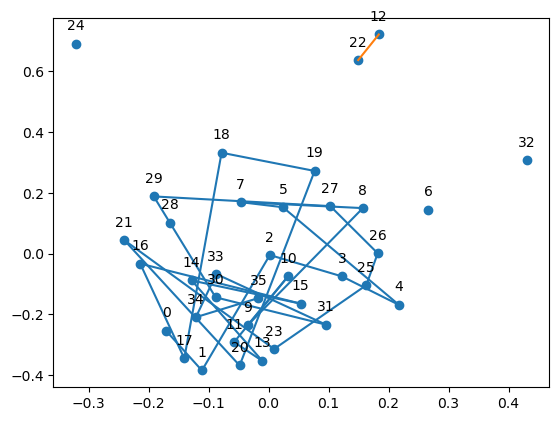

persistence =0.2940637536419941, finding: [26, 28]
 [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35], [12, 22]]
merging
[[28]]
[[0, 0]]
pbow:
[array([19., 11.]), array([1., 0.])]
[[ 0.         21.09502311]
 [21.09502311  0.        ]]
score x0.55: [0.16129032258064516] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35], [12, 22]]


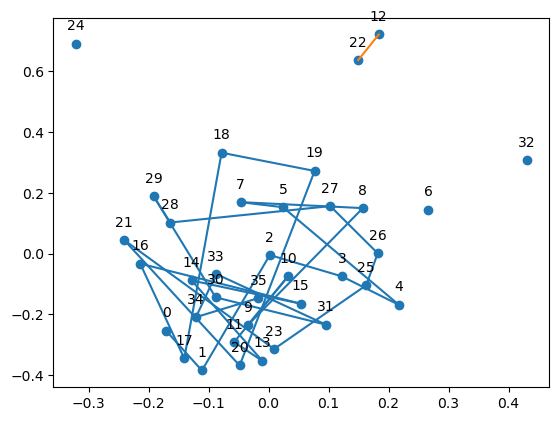

persistence =0.4073746574677636, finding: [6, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35], [12, 22]]
merging
[[6]]
[[0, 0]]
pbow:
[array([22.,  9.]), array([1., 0.])]
[[ 0.         22.84731932]
 [22.84731932  0.        ]]
score x0.5666666666666667: [0.15625] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35], [12, 22]]


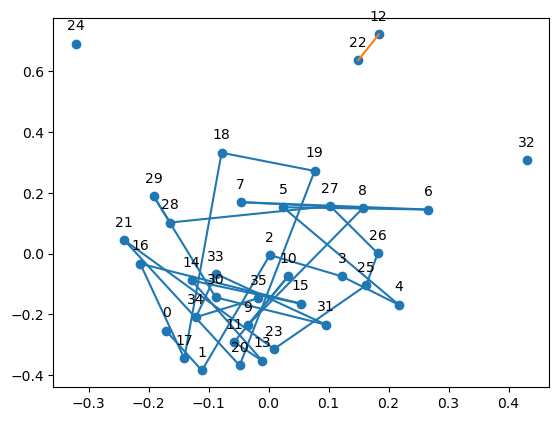

persistence =0.42851215141242394, finding: [19, 22]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35]]
merging
[[12, 22], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  22.847319317591726 22.847319317591726
score x0.5666666666666667: [0.14705882352941177] 
total score : 0.8611111111111112

persistence =0.5221474690833143, finding: [6, 32]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[32]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



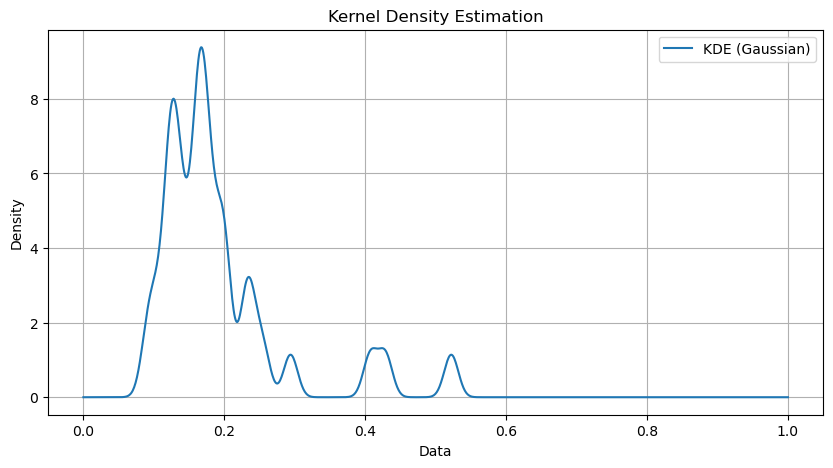

32 (36, 36)


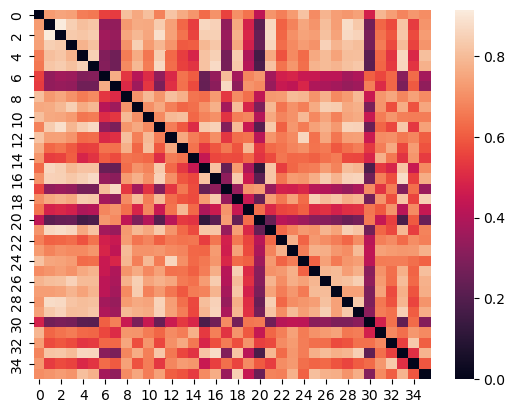

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


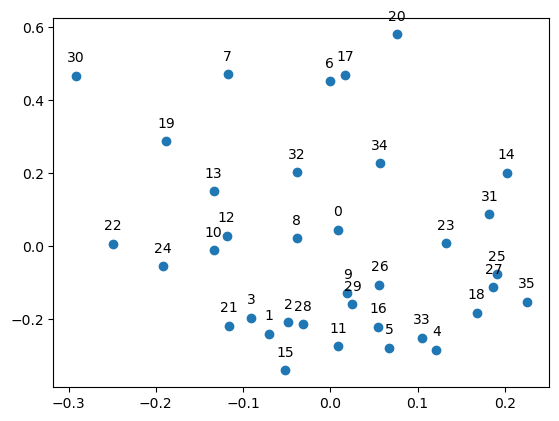

d 0 0 0.0 inf []
d 0 1 0.0 0.30672244228121026 [[17, 30]]
d 0 2 0.0 0.28622303762003065 [[7, 19]]
d 0 3 0.0 0.2701418133258783 [[17, 20]]
d 0 4 0.0 0.24139279049819795 [[13, 32]]
d 0 5 0.0 0.22671198839144502 [[14, 31]]
d 0 6 0.0 0.22293619775000728 [[22, 23]]
d 0 7 0.0 0.21232282247157663 [[0, 31]]
d 0 8 0.0 0.20763731646640204 [[13, 19]]
d 0 9 0.0 0.20259641792687233 [[23, 29]]
d 0 10 0.0 0.20027764861749908 [[8, 23]]
d 0 11 0.0 0.19697829501724717 [[6, 17]]
d 0 12 0.0 0.19237105247658715 [[0, 10]]
d 0 13 0.0 0.19225142522888428 [[10, 13]]
d 0 14 0.0 0.1921108734027257 [[0, 8]]
d 0 15 0.0 0.17881399456856728 [[0, 12]]
d 0 16 0.0 0.1658432370117151 [[32, 34]]
d 0 17 0.0 0.16288404800428036 [[9, 27]]
d 0 18 0.0 0.1612334419971695 [[4, 18]]
d 0 19 0.0 0.15549310172627606 [[18, 35]]
d 0 20 0.0 0.15530672221476205 [[3, 9]]
d 0 21 0.0 0.1538367250107665 [[18, 25]]
d 0 22 0.0 0.14836569889770646 [[3, 26]]
d 0 23 0.0 0.14071221594785766 [[16, 29]]
d 0 24 0.0 0.1390175679878427 [[3, 21]]
d 0 

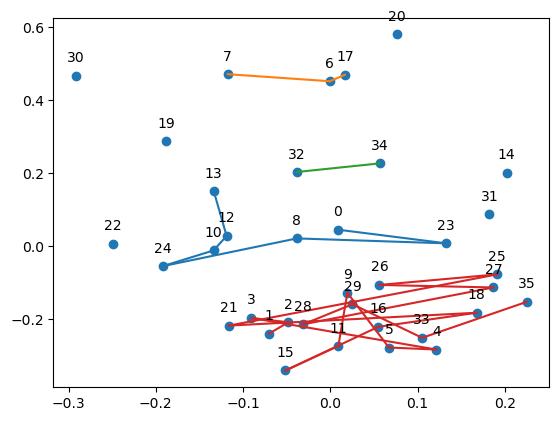

persistence =0.20763731646640204, finding: [23, 29]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 21, 23, 24, 25, 26, 27, 28, 29, 33, 35], [17, 6, 7], [32, 34]]
merging
[[1, 2, 3, 4, 5, 9, 11, 15, 16, 18, 21, 25, 26, 27, 28, 29, 33, 35], [0, 8, 10, 12, 13, 23, 24]]
[[0, 0], [3, 0]]
[0, 3]
merging with pbow_d:  11.0 12.649110640673518
pbow:
[array([ 8., 16.]), array([1., 1.]), array([1., 0.])]
[[ 0.         16.55294536 17.4642492 ]
 [16.55294536  0.          1.        ]
 [17.4642492   1.          0.        ]]
score x0.5: [0.08] [0.0] [1.0] 
total score : 0.9444444444444444

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 21, 23, 24, 25, 26, 27, 28, 29, 33, 35], [17, 6, 7], [32, 34]]


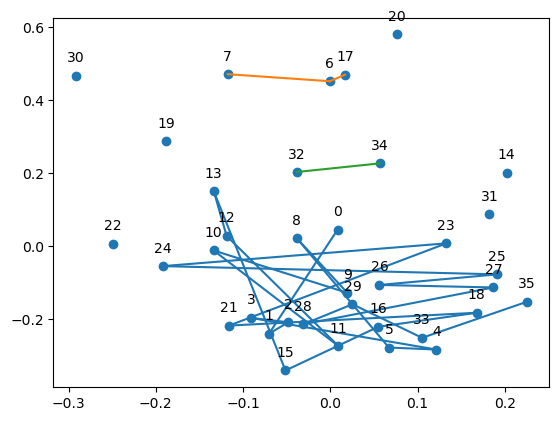

persistence =0.21232282247157663, finding: [13, 19]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 33, 35], [17, 6, 7], [32, 34]]
merging
[[19]]
[[0, 0]]
pbow:
[array([ 9., 16.]), array([1., 1.]), array([1., 0.])]
[[ 0.         17.         17.88854382]
 [17.          0.          1.        ]
 [17.88854382  1.          0.        ]]
score x0.5166666666666667: [0.07692307692307693] [0.0] [1.0] 
total score : 0.9444444444444444

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 33, 35], [17, 6, 7], [32, 34]]


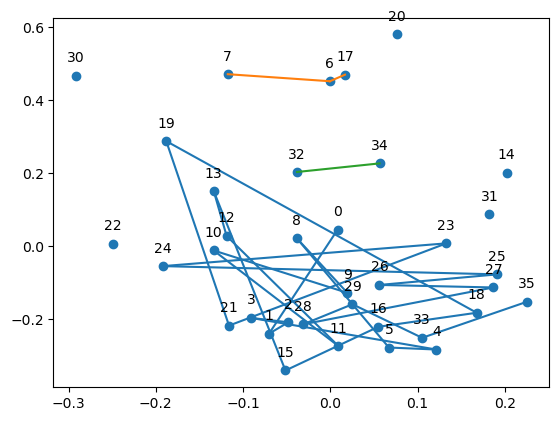

persistence =0.22293619775000728, finding: [0, 31]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]
merging
[[31]]
[[0, 0]]
pbow:
[array([18.,  8.]), array([1., 1.]), array([1., 0.])]
[[ 0.         18.38477631 18.78829423]
 [18.38477631  0.          1.        ]
 [18.78829423  1.          0.        ]]
score x0.5333333333333333: [0.1111111111111111] [0.0] [1.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]


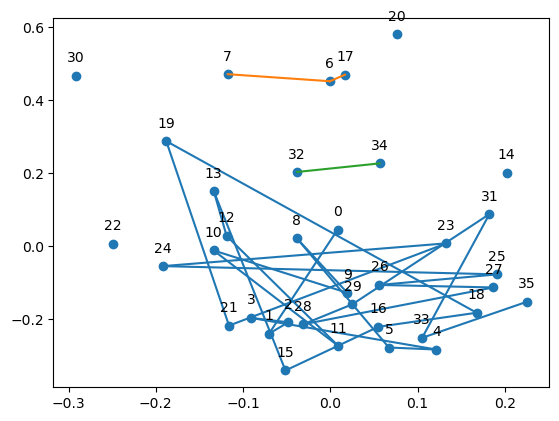

persistence =0.22671198839144502, finding: [22, 23]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]
merging
[[22]]
[[0, 0]]
pbow:
[array([18.,  9.]), array([1., 1.]), array([1., 0.])]
[[ 0.         18.78829423 19.23538406]
 [18.78829423  0.          1.        ]
 [19.23538406  1.          0.        ]]
score x0.55: [0.10714285714285714] [0.0] [1.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]


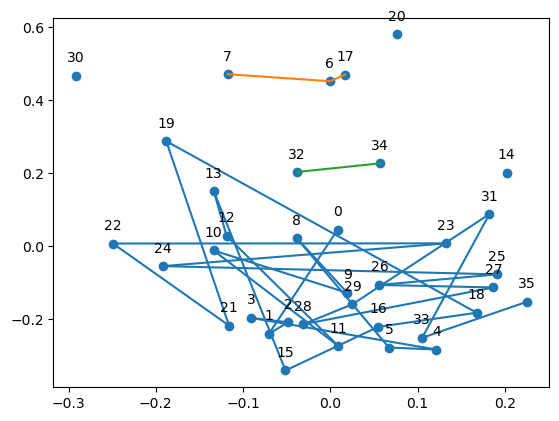

persistence =0.24139279049819795, finding: [14, 31]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]
merging
[[14]]
[[0, 0]]
pbow:
[array([18., 10.]), array([1., 1.]), array([1., 0.])]
[[ 0.         19.23538406 19.72308292]
 [19.23538406  0.          1.        ]
 [19.72308292  1.          0.        ]]
score x0.5666666666666667: [0.10344827586206896] [0.0] [1.0] 
total score : 0.9166666666666666

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35], [17, 6, 7], [32, 34]]


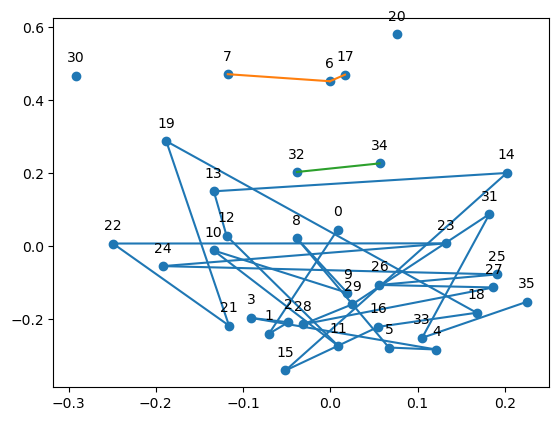

persistence =0.2701418133258783, finding: [13, 32]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35], [17, 6, 7]]
merging
[[32, 34], [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  19.72308292331602 19.72308292331602
pbow:
[array([ 8., 10., 12.]), array([0., 1., 1.])]
[[ 0.         16.30950643]
 [16.30950643  0.        ]]
score x0.5666666666666667: [0.16129032258064516] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35], [17, 6, 7]]


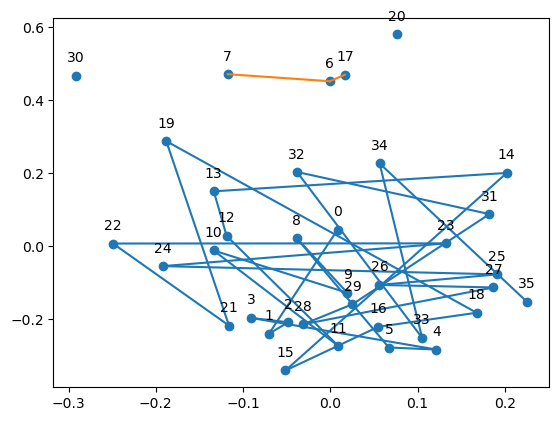

persistence =0.28622303762003065, finding: [17, 20]
 [[17, 20, 6, 7], [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]
merging
[[20]]
[[1, 0]]
pbow:
[array([0., 1., 1., 1.]), array([ 8.,  9., 12.,  1.])]
[[ 0.         15.77973384]
 [15.77973384  0.        ]]
score x0.5833333333333334: [0.0] [0.16129032258064516] 
total score : 0.8611111111111112

[[17, 20, 6, 7], [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]


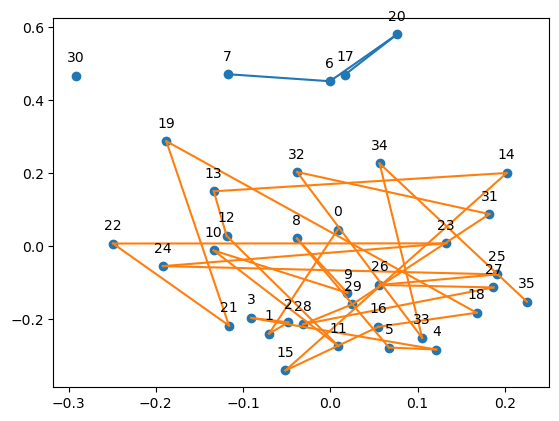

persistence =0.30672244228121026, finding: [7, 19]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35]]
merging
[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35], [6, 7, 17, 20]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.7797338380595 15.7797338380595
score x0.5833333333333334: [0.14285714285714285] 
total score : 0.8611111111111112



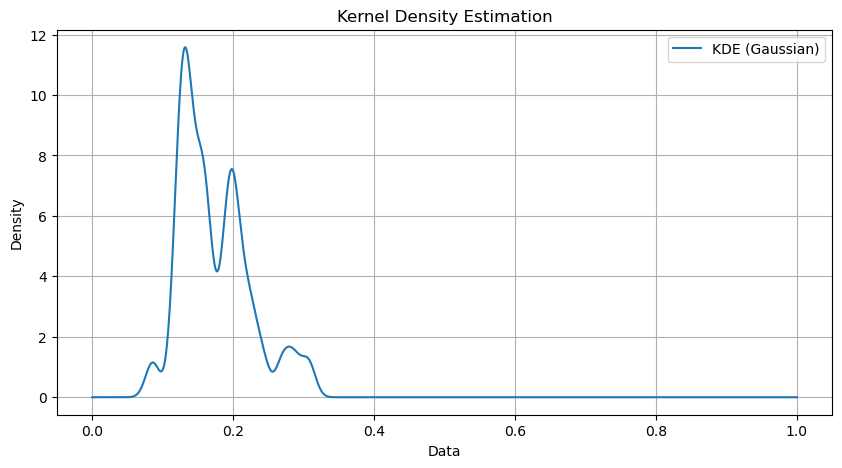

30 (36, 36)


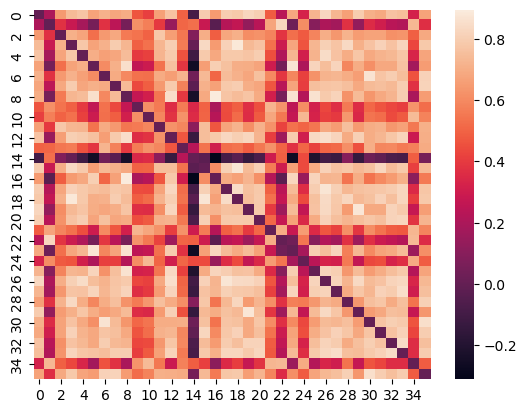

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


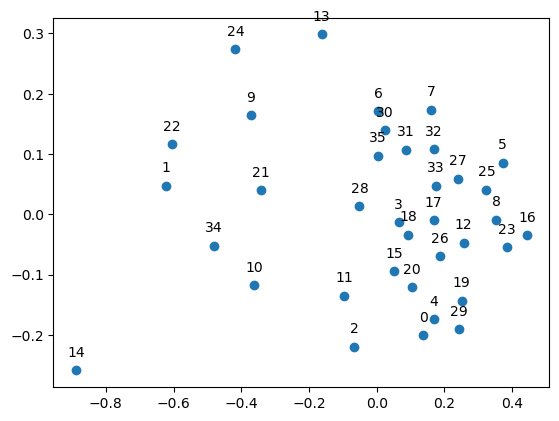

d 0 0 0.0 inf []
d 0 1 0.0 0.47045708691217913 [[1, 14]]
d 0 2 0.0 0.36040423162664625 [[10, 28]]
d 0 3 0.0 0.27585239932172834 [[9, 21]]
d 0 4 0.0 0.27555904089526906 [[6, 13]]
d 0 5 0.0 0.27205073502763877 [[21, 34]]
d 0 6 0.0 0.26704441705767956 [[10, 24]]
d 0 7 0.0 0.2612943051971224 [[22, 34]]
d 0 8 0.0 0.2560024509778911 [[10, 34]]
d 0 9 0.0 0.2417962395229245 [[11, 28]]
d 0 10 0.0 0.220136183844435 [[2, 11]]
d 0 11 0.0 0.19273070278552784 [[28, 35]]
d 0 12 0.0 0.18178069214810755 [[7, 35]]
d 0 13 0.0 0.17367829561026293 [[20, 33]]
d 0 14 0.0 0.17249022889910637 [[1, 22]]
d 0 15 0.0 0.17178462310419995 [[15, 31]]
d 0 16 0.0 0.16908566474700482 [[0, 26]]
d 0 17 0.0 0.16870515092356664 [[26, 33]]
d 0 18 0.0 0.16398502147256444 [[26, 29]]
d 0 19 0.0 0.16104281722984393 [[3, 28]]
d 0 20 0.0 0.15532127564705833 [[32, 33]]
d 0 21 0.0 0.15522033383751088 [[4, 26]]
d 0 22 0.0 0.155021615799102 [[17, 18]]
d 0 23 0.0 0.15008250761694475 [[8, 12]]
d 0 24 0.0 0.149455761293251 [[27, 33]]
d 0

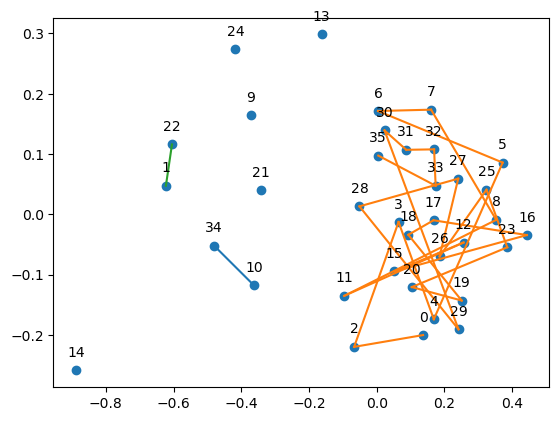

persistence =0.26704441705767956, finding: [22, 34]
 [[1, 34, 10, 22], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[1, 22], [34, 10]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  1.4142135623730951 23.08679276123039
pbow:
[array([0., 2., 1., 0.]), array([8., 2., 7., 9.])]
[[ 0.         13.45362405]
 [13.45362405  0.        ]]
score x0.5166666666666667: [0.25] [0.18518518518518517] 
total score : 0.8333333333333334

[[1, 34, 10, 22], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]


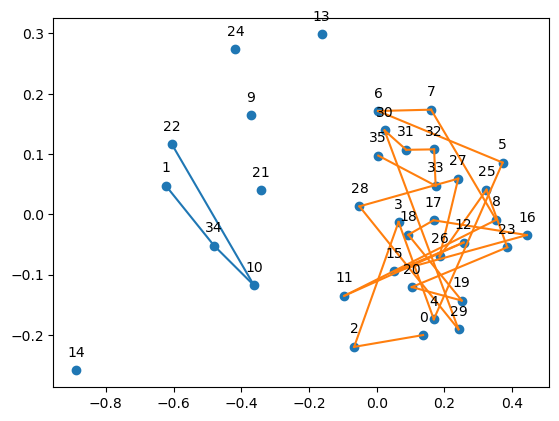

persistence =0.27205073502763877, finding: [10, 24]
 [[1, 34, 10, 22, 24], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[24]]
[[0, 0]]
pbow:
[array([0., 0., 1., 3., 0.]), array([9., 2., 7., 0., 8.])]
[[ 0.         13.92838828]
 [13.92838828  0.        ]]
score x0.5333333333333333: [0.2] [0.18518518518518517] 
total score : 0.8333333333333334

[[1, 34, 10, 22, 24], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]


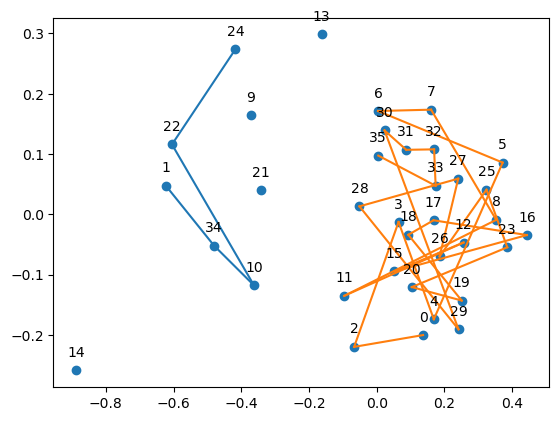

persistence =0.27555904089526906, finding: [21, 34]
 [[1, 34, 21, 22, 24, 10], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[21]]
[[0, 0]]
pbow:
[array([0., 0., 0., 1., 4.]), array([8., 2., 9., 7., 0.])]
[[ 0.         14.17744688]
 [14.17744688  0.        ]]
score x0.55: [0.16666666666666666] [0.18518518518518517] 
total score : 0.8333333333333334

[[1, 34, 21, 22, 24, 10], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]


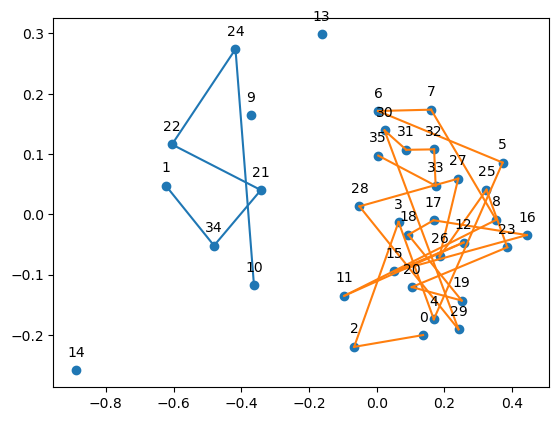

persistence =0.27585239932172834, finding: [6, 13]
 [[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22, 24, 10]]
merging
[[13]]
[[1, 0]]
pbow:
[array([9., 2., 7., 1., 8.]), array([0., 0., 1., 4., 0.])]
[[ 0.         13.92838828]
 [13.92838828  0.        ]]
score x0.5666666666666667: [0.17857142857142858] [0.16666666666666666] 
total score : 0.8333333333333334

[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 34, 21, 22, 24, 10]]


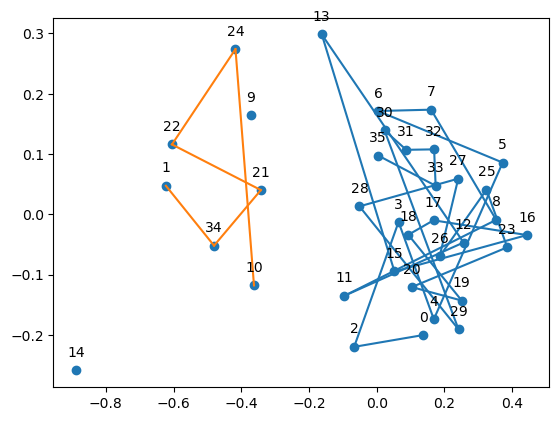

persistence =0.36040423162664625, finding: [9, 21]
 [[1, 34, 21, 22, 24, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]
merging
[[9]]
[[1, 0]]
pbow:
[array([0., 0., 1., 5., 0.]), array([9., 2., 7., 1., 8.])]
[[ 0.         14.17744688]
 [14.17744688  0.        ]]
score x0.5833333333333334: [0.14285714285714285] [0.17857142857142858] 
total score : 0.8333333333333334

[[1, 34, 21, 22, 24, 9, 10], [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35]]


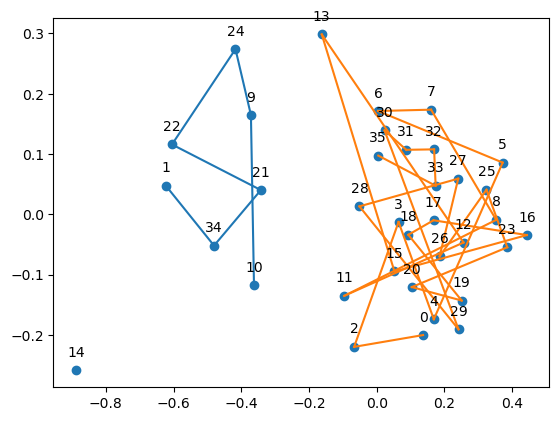

persistence =0.47045708691217913, finding: [10, 28]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35], [1, 9, 10, 21, 22, 24, 34]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  14.177446878757825 14.177446878757825
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



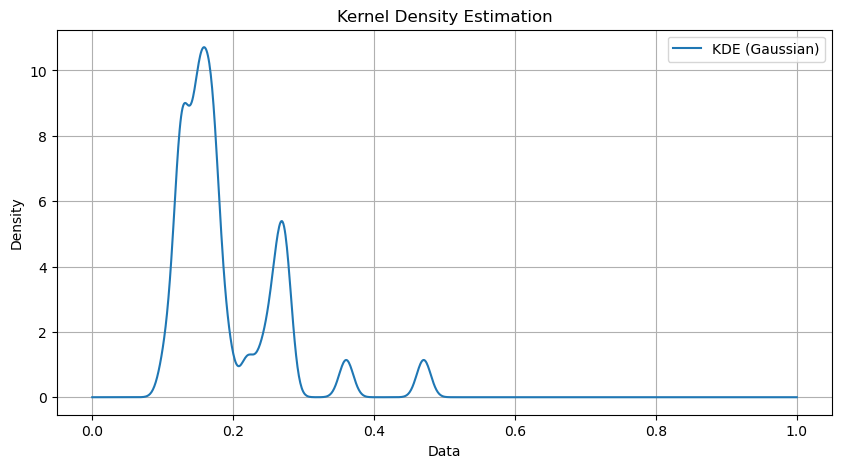

28 (36, 36)


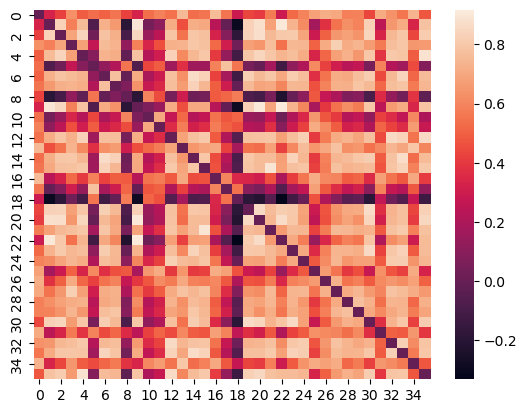

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


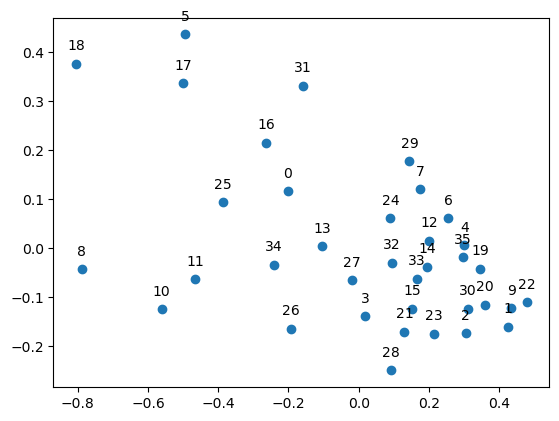

d 0 0 0.0 inf []
d 0 1 0.0 0.4234519402167338 [[8, 18]]
d 0 2 0.0 0.4005924884240095 [[8, 10]]
d 0 3 0.0 0.32373714970920453 [[17, 25]]
d 0 4 0.0 0.29476101656935316 [[10, 11]]
d 0 5 0.0 0.2908123815846724 [[11, 25]]
d 0 6 0.0 0.29030265036929237 [[0, 31]]
d 0 7 0.0 0.2858021451984887 [[16, 25]]
d 0 8 0.0 0.2701338638024078 [[26, 27]]
d 0 9 0.0 0.24742821126520953 [[0, 13]]
d 0 10 0.0 0.24094578166246727 [[0, 16]]
d 0 11 0.0 0.22688283154653444 [[28, 29]]
d 0 12 0.0 0.2228556202083809 [[5, 17]]
d 0 13 0.0 0.218840132670431 [[13, 27]]
d 0 14 0.0 0.20444772200596484 [[14, 29]]
d 0 15 0.0 0.20392023849439211 [[13, 34]]
d 0 16 0.0 0.20295006940807747 [[3, 14]]
d 0 17 0.0 0.18019146387437945 [[12, 24]]
d 0 18 0.0 0.17731584847872717 [[3, 27]]
d 0 19 0.0 0.1664385335094053 [[7, 14]]
d 0 20 0.0 0.1649609845315605 [[15, 33]]
d 0 21 0.0 0.1614253920608535 [[12, 33]]
d 0 22 0.0 0.149220958024313 [[20, 35]]
d 0 23 0.0 0.14626157648282778 [[12, 32]]
d 0 24 0.0 0.1459526520876573 [[23, 30]]
d 0 25 

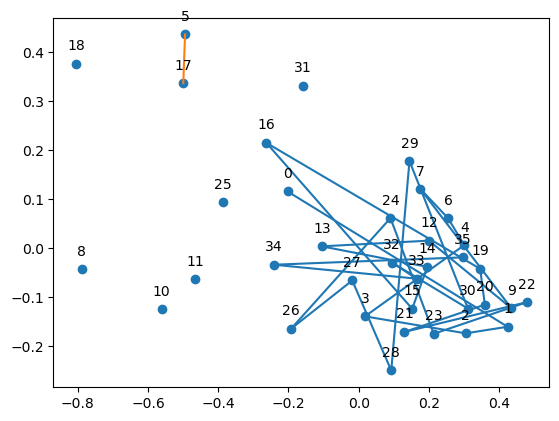

persistence =0.29030265036929237, finding: [16, 25]
 [[0, 1, 2, 3, 4, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35], [5, 17]]
merging
[[25]]
[[0, 0]]
pbow:
[array([19.,  9.]), array([0., 1.])]
[[ 0.         20.61552813]
 [20.61552813  0.        ]]
score x0.5166666666666667: [0.1724137931034483] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35], [5, 17]]


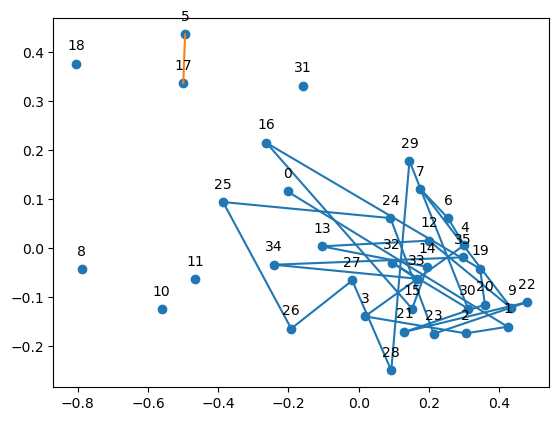

persistence =0.2908123815846724, finding: [0, 31]
 [[0, 1, 2, 3, 4, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]
merging
[[31]]
[[0, 0]]
pbow:
[array([19., 10.]), array([0., 1.])]
[[ 0.         21.02379604]
 [21.02379604  0.        ]]
score x0.5333333333333333: [0.2] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]


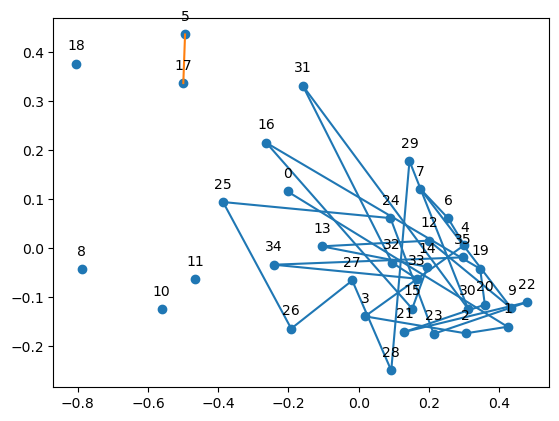

persistence =0.29476101656935316, finding: [11, 25]
 [[0, 1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]
merging
[[11]]
[[0, 0]]
pbow:
[array([11., 19.]), array([1., 0.])]
[[ 0.         21.47091055]
 [21.47091055  0.        ]]
score x0.55: [0.1935483870967742] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]


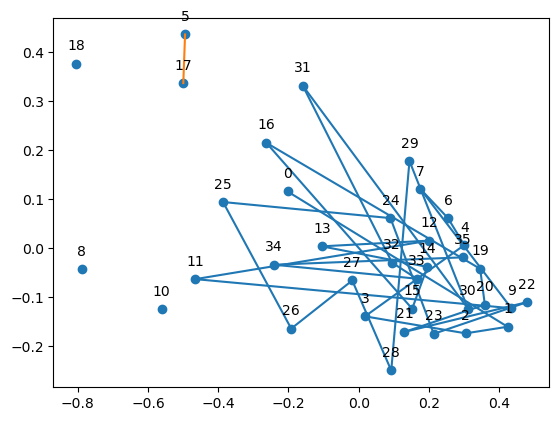

persistence =0.32373714970920453, finding: [10, 11]
 [[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]
merging
[[10]]
[[0, 0]]
pbow:
[array([19., 12.]), array([0., 1.])]
[[ 0.        21.9544984]
 [21.9544984  0.       ]]
score x0.5666666666666667: [0.1875] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [5, 17]]


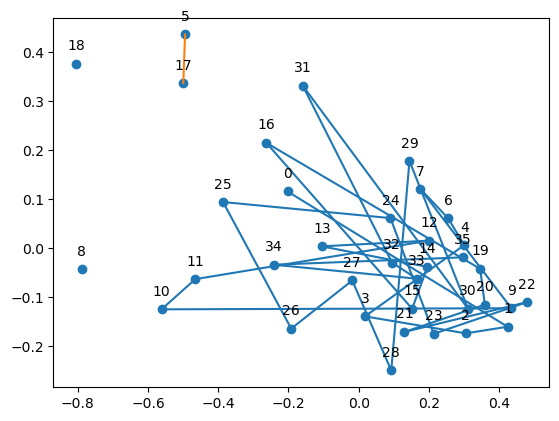

persistence =0.4005924884240095, finding: [17, 25]
 [[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[5, 17], [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  21.95449840010015 21.95449840010015
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.4234519402167338, finding: [8, 10]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[8]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



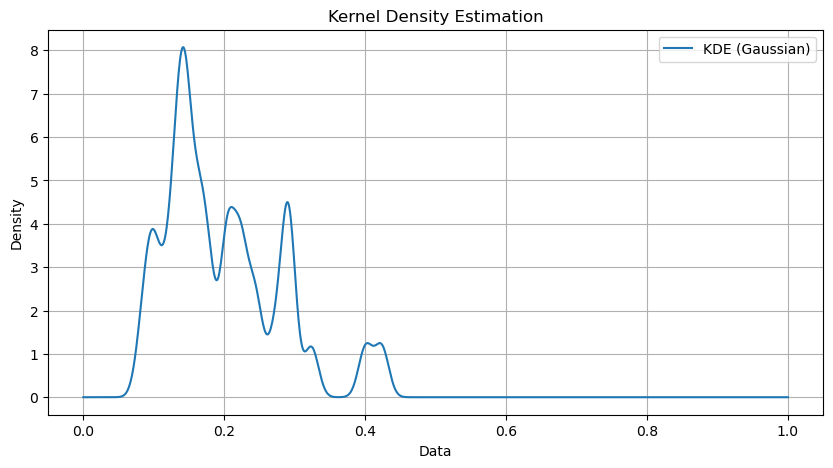

26 (36, 36)


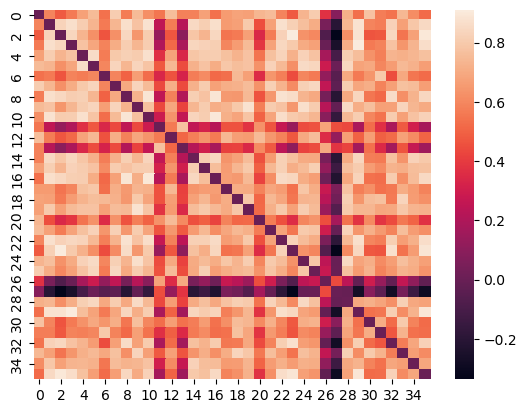

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


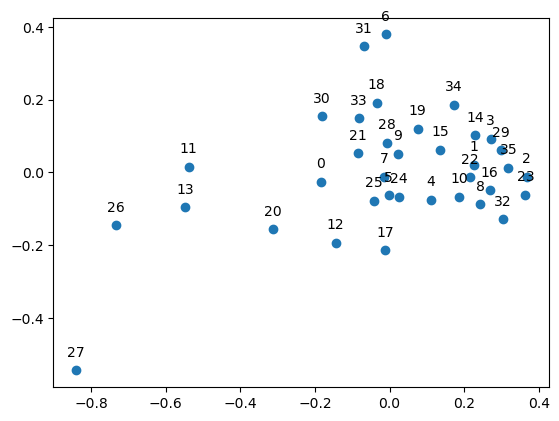

d 0 0 0.0 inf []
d 0 1 0.0 0.5508523857370713 [[11, 27]]
d 0 2 0.0 0.36915614493242765 [[11, 20]]
d 0 3 0.0 0.3014740298562394 [[13, 26]]
d 0 4 0.0 0.24653110236399933 [[12, 20]]
d 0 5 0.0 0.2389272042298599 [[0, 12]]
d 0 6 0.0 0.22828112045541338 [[18, 31]]
d 0 7 0.0 0.22714593727399623 [[11, 13]]
d 0 8 0.0 0.20970903181658473 [[5, 17]]
d 0 9 0.0 0.20352430686187084 [[6, 31]]
d 0 10 0.0 0.19596417180316528 [[30, 33]]
d 0 11 0.0 0.18770579830499012 [[0, 7]]
d 0 12 0.0 0.17576786572037595 [[14, 34]]
d 0 13 0.0 0.17289538761208578 [[3, 15]]
d 0 14 0.0 0.16946652966137787 [[21, 28]]
d 0 15 0.0 0.16403694152031467 [[9, 33]]
d 0 16 0.0 0.1630518042660406 [[18, 33]]
d 0 17 0.0 0.15855335699517137 [[5, 25]]
d 0 18 0.0 0.15389778929367903 [[7, 25]]
d 0 19 0.0 0.1488101431252732 [[1, 14]]
d 0 20 0.0 0.14407530541518498 [[9, 28]]
d 0 21 0.0 0.14242744570212396 [[5, 24]]
d 0 22 0.0 0.13893619882846986 [[4, 5]]
d 0 23 0.0 0.12805487261896387 [[9, 24]]
d 0 24 0.0 0.12634130829851276 [[23, 32]]
d 0 

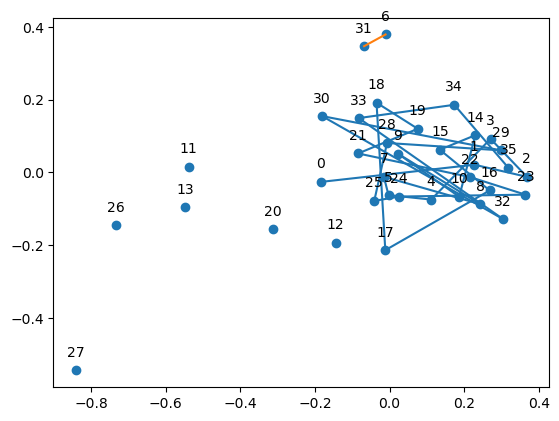

persistence =0.22828112045541338, finding: [11, 13]
 [[11, 13], [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 35], [6, 31]]
merging
[]
[]
pbow:
[array([1., 0.]), array([10., 17.]), array([1., 0.])]
[[ 0.         19.23538406  0.        ]
 [19.23538406  0.         19.23538406]
 [ 0.         19.23538406  0.        ]]
score x0.5333333333333333: [0.0] [0.17857142857142858] [0.5] 
total score : 0.8333333333333334

[[11, 13], [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 35], [6, 31]]


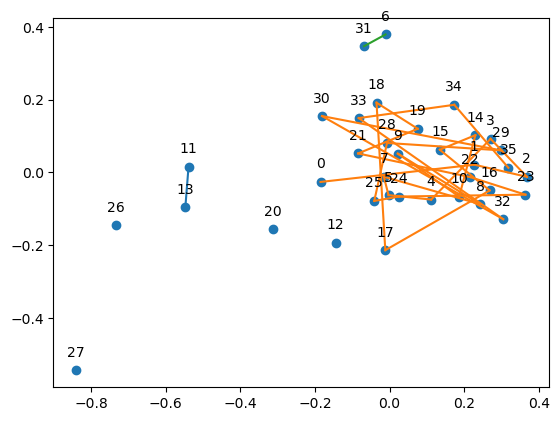

persistence =0.2389272042298599, finding: [18, 31]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]
merging
[[6, 31], [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 35]]
[[1, 0], [2, 0]]
[0, 1, 2]
merging with pbow_d:  19.235384061671343 19.235384061671343
pbow:
[array([12., 17.]), array([1., 0.])]
[[ 0.         20.24845673]
 [20.24845673  0.        ]]
score x0.5333333333333333: [0.2] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]


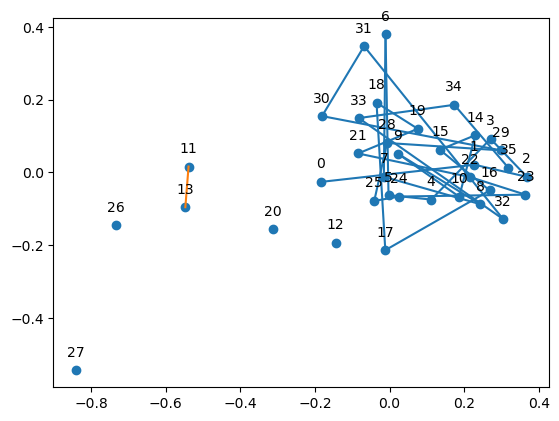

persistence =0.24653110236399933, finding: [0, 12]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]
merging
[[12]]
[[0, 0]]
pbow:
[array([12., 18.]), array([1., 0.])]
[[ 0.         21.09502311]
 [21.09502311  0.        ]]
score x0.55: [0.1935483870967742] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]


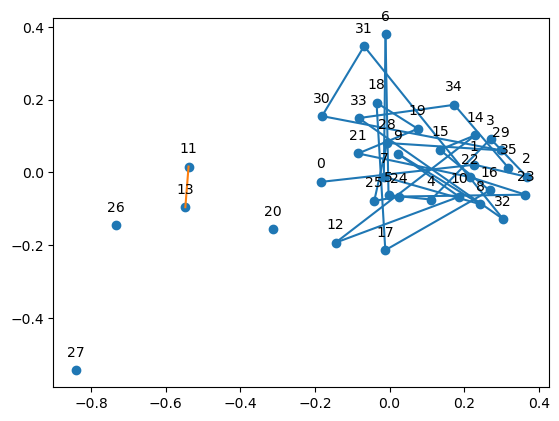

persistence =0.3014740298562394, finding: [12, 20]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]
merging
[[20]]
[[0, 0]]
pbow:
[array([10., 21.]), array([1., 0.])]
[[ 0.         22.84731932]
 [22.84731932  0.        ]]
score x0.5666666666666667: [0.1875] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13]]


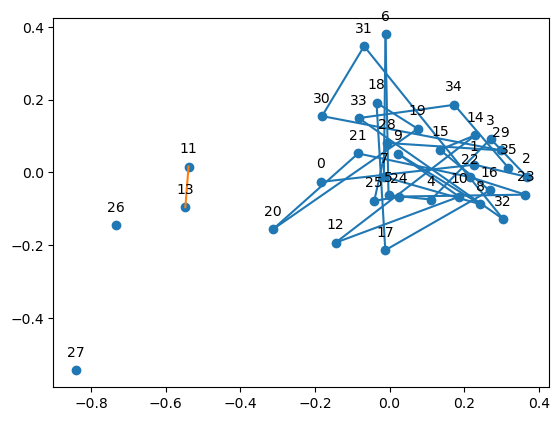

persistence =0.36915614493242765, finding: [13, 26]
 [[26, 11, 13], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[26]]
[[1, 0]]
pbow:
[array([0., 2., 0.]), array([13.,  5., 13.])]
[[ 0.         18.62793601]
 [18.62793601  0.        ]]
score x0.5833333333333334: [0.0] [0.1875] 
total score : 0.8333333333333334

[[26, 11, 13], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35]]


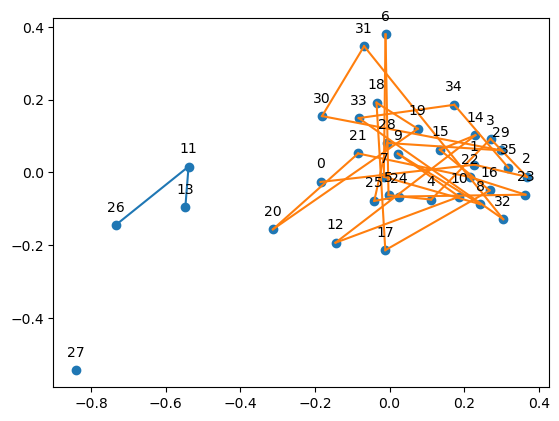

persistence =0.5508523857370713, finding: [11, 20]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35], [11, 13, 26]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  18.627936010197157 18.627936010197157
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



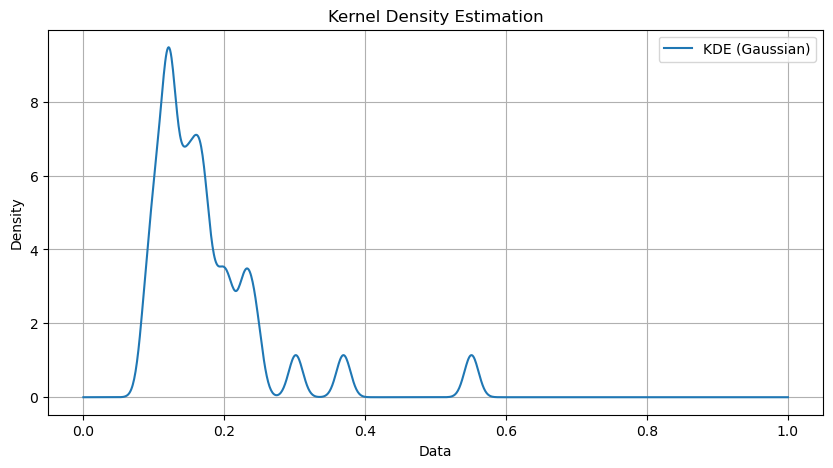

24 (36, 36)


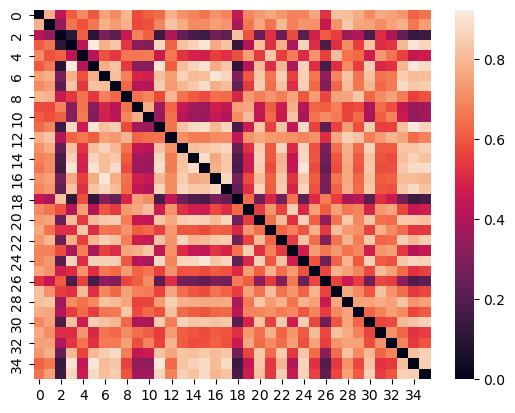

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


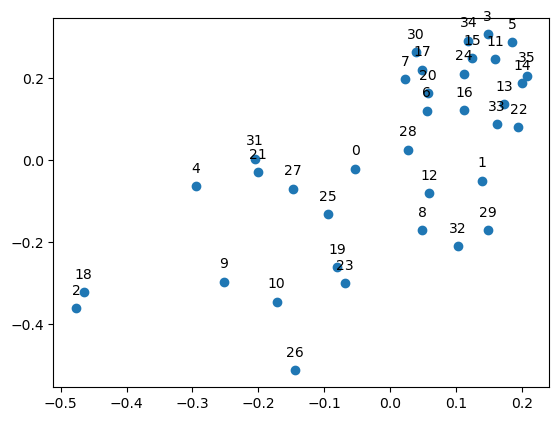

d 0 0 0.0 inf []
d 0 1 0.0 0.2974968528491745 [[10, 26]]
d 0 2 0.0 0.25657934392886084 [[9, 18]]
d 0 3 0.0 0.24130423506213117 [[19, 32]]
d 0 4 0.0 0.21807256941873243 [[9, 23]]
d 0 5 0.0 0.206926631738252 [[12, 32]]
d 0 6 0.0 0.19152699316063226 [[25, 31]]
d 0 7 0.0 0.1851113777481701 [[0, 28]]
d 0 8 0.0 0.18437518903233607 [[21, 27]]
d 0 9 0.0 0.1801190459700972 [[2, 18]]
d 0 10 0.0 0.1778991797884486 [[12, 29]]
d 0 11 0.0 0.17711373042694545 [[0, 27]]
d 0 12 0.0 0.1770891157528428 [[27, 31]]
d 0 13 0.0 0.169716862595354 [[10, 23]]
d 0 14 0.0 0.16643498450805871 [[4, 21]]
d 0 15 0.0 0.16399703227349827 [[8, 29]]
d 0 16 0.0 0.16276335881601411 [[1, 28]]
d 0 17 0.0 0.16192050004722613 [[20, 28]]
d 0 18 0.0 0.1487586066273615 [[19, 23]]
d 0 19 0.0 0.14631072510305643 [[12, 28]]
d 0 20 0.0 0.1359138452085893 [[13, 30]]
d 0 21 0.0 0.13030097159520615 [[13, 22]]
d 0 22 0.0 0.12694019218175345 [[13, 17]]
d 0 23 0.0 0.12632467354610222 [[17, 20]]
d 0 24 0.0 0.12536097901699117 [[16, 17]]
d 0

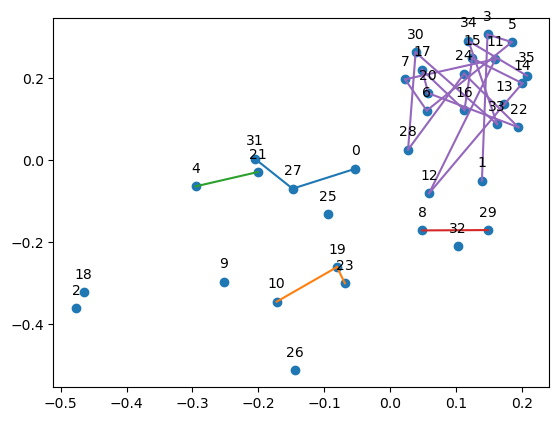

persistence =0.1801190459700972, finding: [12, 29]
 [[1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [0, 27, 31], [10, 19, 23], [4, 21]]
merging
[[1, 3, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 30, 33, 34, 35], [8, 29]]
[[3, 0], [4, 0]]
[0, 3, 4]
merging with pbow_d:  15.297058540778355 15.297058540778355
pbow:
[array([15.,  6.]), array([0., 2.]), array([0., 2.]), array([0., 1.])]
[[ 0.        15.5241747 15.5241747 15.8113883]
 [15.5241747  0.         0.         1.       ]
 [15.5241747  0.         0.         1.       ]
 [15.8113883  1.         1.         0.       ]]
score x0.5: [0.18181818181818182] [0.3333333333333333] [0.0] [0.0] 
total score : 0.8611111111111112

[[1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [0, 27, 31], [10, 19, 23], [4, 21]]


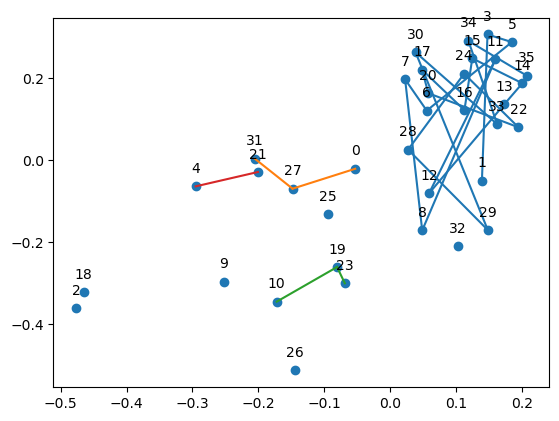

persistence =0.18437518903233607, finding: [2, 18]
 [[2, 18], [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [0, 27, 31], [10, 19, 23], [4, 21]]
merging
[]
[]
pbow:
[array([1., 0.]), array([ 5., 16.]), array([2., 0.]), array([2., 0.]), array([1., 0.])]
[[ 0.        16.4924225  1.         1.         0.       ]
 [16.4924225  0.        16.2788206 16.2788206 16.4924225]
 [ 1.        16.2788206  0.         0.         1.       ]
 [ 1.        16.2788206  0.         0.         1.       ]
 [ 0.        16.4924225  1.         1.         0.       ]]
score x0.5333333333333333: [0.0] [0.18181818181818182] [0.3333333333333333] [0.0] [0.0] 
total score : 0.8611111111111112

[[2, 18], [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [0, 27, 31], [10, 19, 23], [4, 21]]


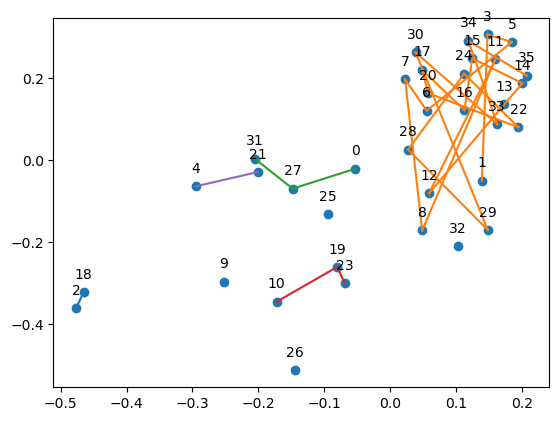

persistence =0.1851113777481701, finding: [21, 27]
 [[0, 4, 21, 27, 31], [2, 18], [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [10, 19, 23]]
merging
[[4, 21], [0, 27, 31]]
[[2, 0], [4, 0]]
[0, 2, 4]
merging with pbow_d:  1.0 16.492422502470642
pbow:
[array([4., 0.]), array([1., 0.]), array([ 5., 16.]), array([2., 0.])]
[[ 0.          3.         16.03121954  2.        ]
 [ 3.          0.         16.4924225   1.        ]
 [16.03121954 16.4924225   0.         16.2788206 ]
 [ 2.          1.         16.2788206   0.        ]]
score x0.5333333333333333: [0.2] [0.0] [0.18181818181818182] [0.0] 
total score : 0.8611111111111112

[[0, 4, 21, 27, 31], [2, 18], [1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [10, 19, 23]]


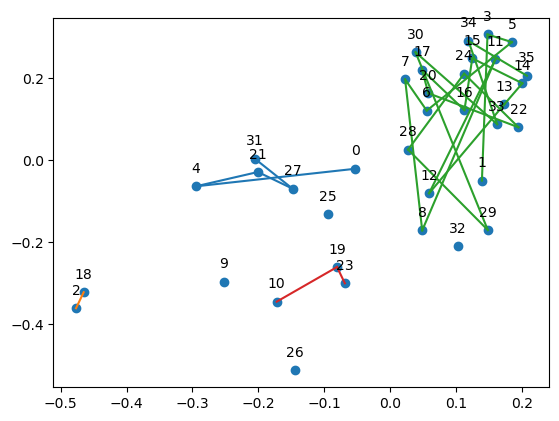

persistence =0.19152699316063226, finding: [0, 28]
 [[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 27, 28, 29, 30, 31, 33, 34, 35], [2, 18], [10, 19, 23]]
merging
[[1, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 22, 24, 28, 29, 30, 33, 34, 35], [0, 4, 21, 27, 31]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  16.0312195418814 16.492422502470642
pbow:
[array([16., 10.]), array([0., 1.]), array([0., 2.])]
[[ 0.         18.35755975 17.88854382]
 [18.35755975  0.          1.        ]
 [17.88854382  1.          0.        ]]
score x0.5333333333333333: [0.18518518518518517] [0.0] [0.0] 
total score : 0.8611111111111112

[[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 27, 28, 29, 30, 31, 33, 34, 35], [2, 18], [10, 19, 23]]


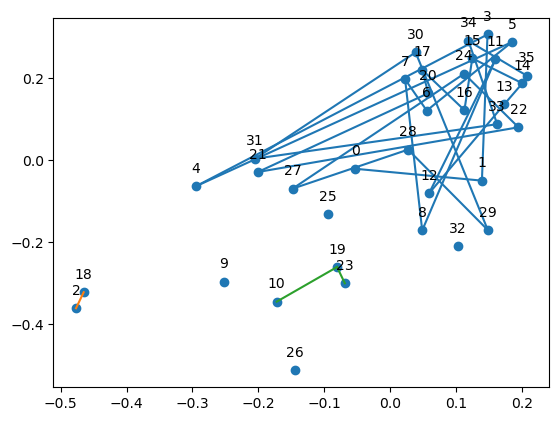

persistence =0.206926631738252, finding: [25, 31]
 [[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35], [2, 18], [10, 19, 23]]
merging
[[25]]
[[0, 0]]
pbow:
[array([11., 16.]), array([1., 0.]), array([2., 0.])]
[[ 0.         18.86796226 18.35755975]
 [18.86796226  0.          1.        ]
 [18.35755975  1.          0.        ]]
score x0.55: [0.17857142857142858] [0.0] [0.0] 
total score : 0.8611111111111112

[[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35], [2, 18], [10, 19, 23]]


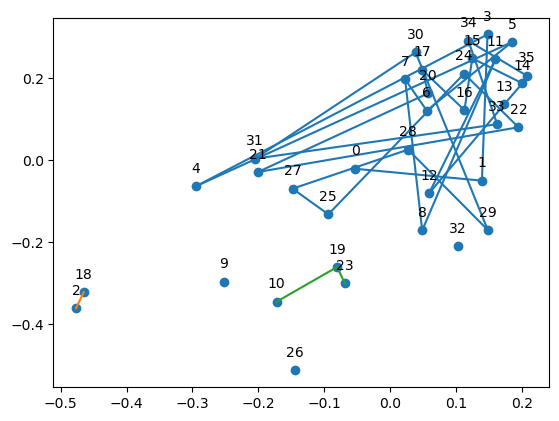

persistence =0.21807256941873243, finding: [12, 32]
 [[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18], [10, 19, 23]]
merging
[[32]]
[[0, 0]]
pbow:
[array([12., 16.]), array([1., 0.]), array([2., 0.])]
[[ 0.         19.41648784 18.86796226]
 [19.41648784  0.          1.        ]
 [18.86796226  1.          0.        ]]
score x0.5666666666666667: [0.20689655172413793] [0.0] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18], [10, 19, 23]]


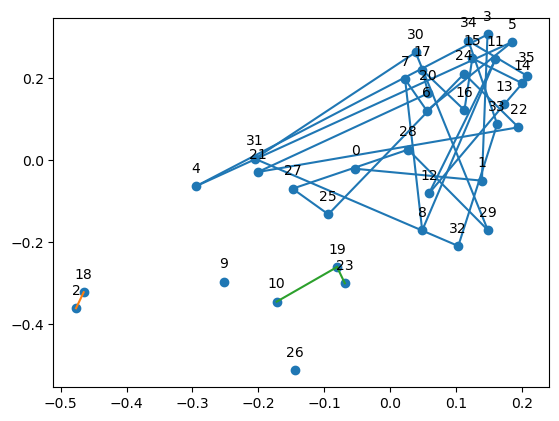

persistence =0.24130423506213117, finding: [9, 23]
 [[9, 10, 19, 23], [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]
merging
[[9]]
[[2, 0]]
pbow:
[array([3., 0.]), array([12., 16.]), array([1., 0.])]
[[ 0.         18.35755975  2.        ]
 [18.35755975  0.         19.41648784]
 [ 2.         19.41648784  0.        ]]
score x0.5833333333333334: [0.0] [0.20689655172413793] [0.0] 
total score : 0.8333333333333334

[[9, 10, 19, 23], [0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]


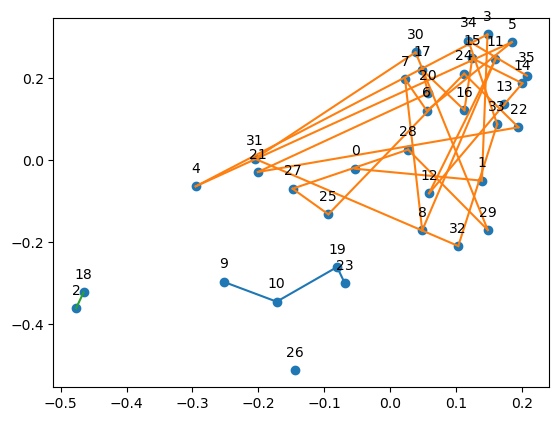

persistence =0.25657934392886084, finding: [19, 32]
 [[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]
merging
[[0, 1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 10, 19, 23]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  18.35755975068582 19.4164878389476
pbow:
[array([16., 16.]), array([0., 1.])]
[[ 0.        21.9317122]
 [21.9317122  0.       ]]
score x0.5833333333333334: [0.18181818181818182] [0.0] 
total score : 0.8333333333333334

[[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35], [2, 18]]


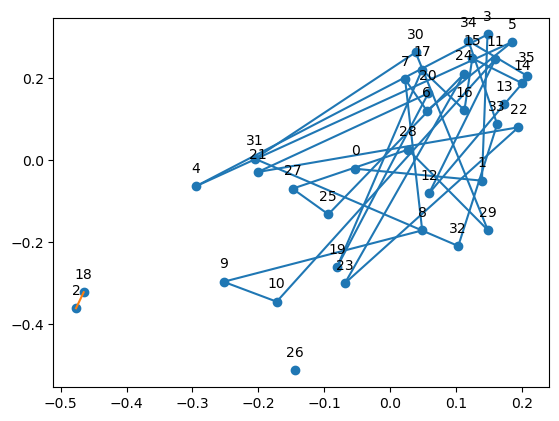

persistence =0.2974968528491745, finding: [9, 18]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[2, 18], [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  21.93171219946131 21.93171219946131
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



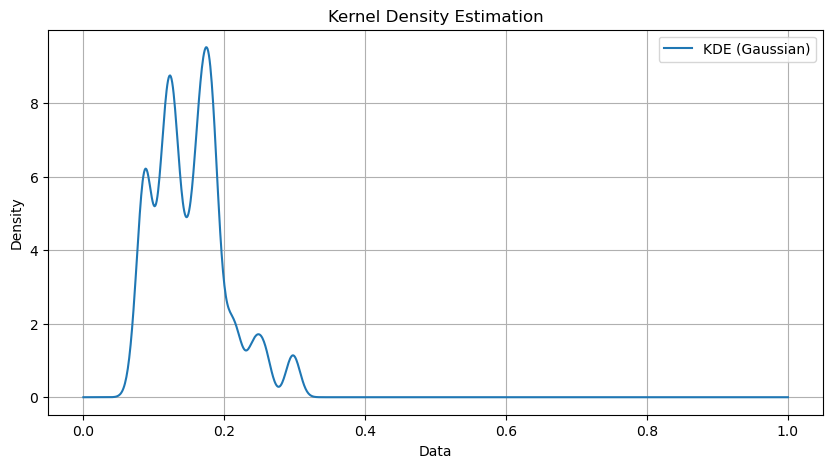

22 (36, 36)


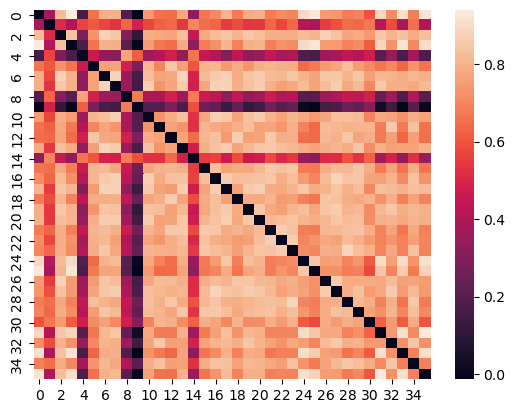

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


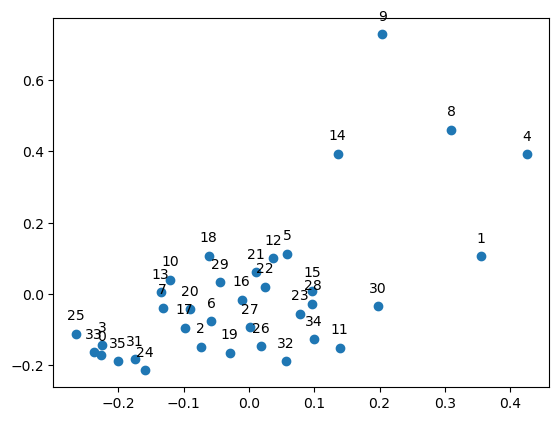

d 0 0 0.0 inf []
d 0 1 0.0 0.3320885665746731 [[1, 30]]
d 0 2 0.0 0.32125391996722685 [[8, 9]]
d 0 3 0.0 0.319781040866862 [[8, 14]]
d 0 4 0.0 0.30062050225683845 [[1, 14]]
d 0 5 0.0 0.23573621328492878 [[4, 8]]
d 0 6 0.0 0.1958441030482434 [[11, 30]]
d 0 7 0.0 0.1557262229548202 [[5, 12]]
d 0 8 0.0 0.15251664806886933 [[28, 34]]
d 0 9 0.0 0.1521756817092752 [[16, 29]]
d 0 10 0.0 0.14966942181687348 [[17, 24]]
d 0 11 0.0 0.14774671667009942 [[11, 32]]
d 0 12 0.0 0.14766944478469934 [[13, 21]]
d 0 13 0.0 0.14573462826424965 [[15, 21]]
d 0 14 0.0 0.14546051149411177 [[12, 21]]
d 0 15 0.0 0.1422699540419612 [[27, 32]]
d 0 16 0.0 0.14127135693091342 [[22, 23]]
d 0 17 0.0 0.14041510103395982 [[12, 18]]
d 0 18 0.0 0.13889066478966594 [[19, 27]]
d 0 19 0.0 0.13498765737376317 [[21, 22]]
d 0 20 0.0 0.13198832970051855 [[17, 20]]
d 0 21 0.0 0.1310196520007475 [[10, 16]]
d 0 22 0.0 0.13002671373213437 [[7, 16]]
d 0 23 0.0 0.12422006642317163 [[6, 17]]
d 0 24 0.0 0.12417136561285036 [[2, 6]]
d 0 

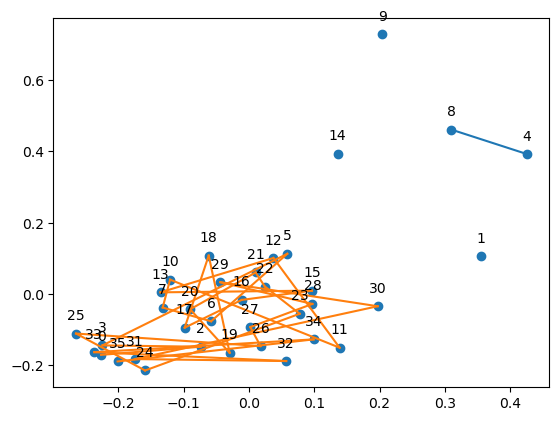

persistence =0.319781040866862, finding: [1, 14]
 [[1, 14], [4, 8], [0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[]
[]
pbow:
[array([0., 1.]), array([0., 1.]), array([29.,  1.])]
[[ 0.  0. 29.]
 [ 0.  0. 29.]
 [29. 29.  0.]]
score x0.5833333333333334: [0.0] [0.0] [0.1935483870967742] 
total score : 0.8333333333333334

[[1, 14], [4, 8], [0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]


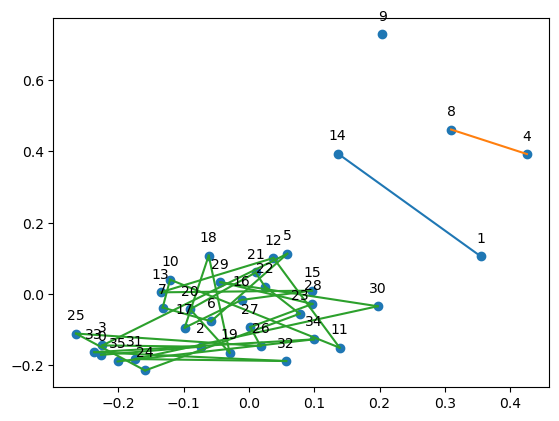

persistence =0.32125391996722685, finding: [8, 14]
 [[8, 1, 4, 14], [0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[8, 4], [1, 14]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  0.0 29.0
pbow:
[array([0., 2., 0., 1.]), array([23.,  0.,  6.,  1.])]
[[ 0.         23.85372088]
 [23.85372088  0.        ]]
score x0.5833333333333334: [0.0] [0.1935483870967742] 
total score : 0.8333333333333334

[[8, 1, 4, 14], [0, 2, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]


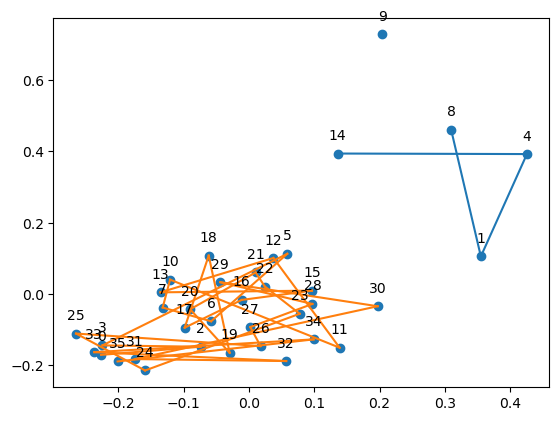

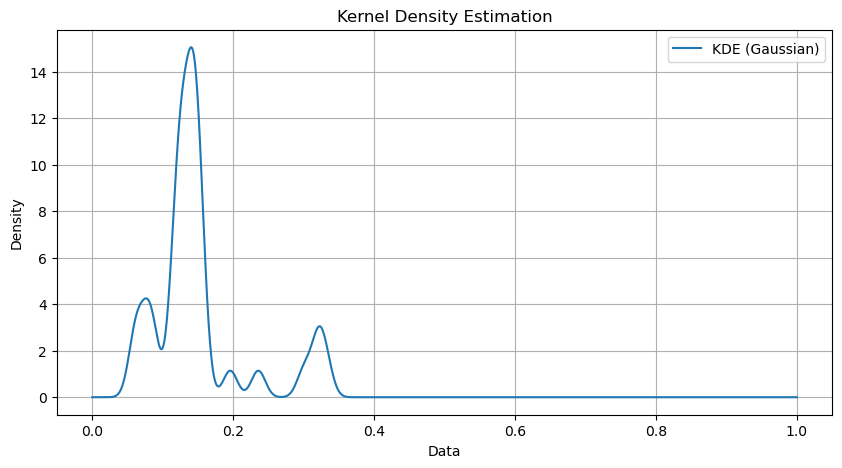

In [ ]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    dv_seq = grouping(data, total_nums, normal_nums, mds_results)

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
